In [13]:
import numpy as np
import matplotlib.pyplot as plt
from util import *
import activation_np as active 
from gradient_check import *
import pdb


CONFIG

In [14]:
class Config(object):
    def __init__(self, num_epoch=1000, batch_size=100, learning_rate=0.0005, momentum_rate=0.9, epochs_to_draw=10, reg=0.00015, num_train=1000, visualize=True):
        self.num_epoch = num_epoch
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.momentum_rate = momentum_rate
        self.epochs_to_draw = epochs_to_draw
        self.reg = reg
        self.num_train = num_train
        self.visualize = visualize

CLASS LAYER


In [15]:
class Layer(object):
    def __init__(self, w_shape, activation, reg = 1e-5):
        """__init__

        :param w_shape: create w with shape w_shape using normal distribution
        :param activation: string, indicating which activation function to be used
        """
        
        mean = 0
        std = 1
        self.w = np.random.normal(0, np.sqrt(2./np.sum(w_shape)), w_shape)
        self.activation = activation
        self.reg = reg
    def forward(self, x):
        """forward
        This function compute the output of this layer
        
        :param x: input
        """
        # [TODO 1.2]
        # print(self.w.shape)
        result=x@self.w
        
        # Compute different types of activation
        if (self.activation == 'sigmoid'):
            result = active.sigmoid(result)
        elif (self.activation == 'relu'):
            result = active.reLU(result)
        elif (self.activation == 'tanh'):
            result = active.tanh(result)
        elif (self.activation == 'softmax'):
            result = active.softmax(result)

        self.output = result
        return result

    def backward(self, x, delta_dot_w_prev):
        """backward
        This function compute the gradient of the loss function with respect to the parameter (w) of this layer

        :param x: input of the layer
        :param delta_dot_w_prev: delta^(l+1) dot product with w^(l+1)T, computed from the next layer (in feedforward direction) or previous layer (in backpropagation direction)
        """
        # [TODO 1.2]
        if(self.activation == 'sigmoid'):
            delta=delta_dot_w_prev*active.sigmoid_grad(x@self.w)
            # print(delta.shape)
            w_grad=x.T@delta
        
        elif(self.activation == 'tanh'):
           delta =delta_dot_w_prev*active.tanh_grad(x@self.w)
           w_grad=x.T@delta

        elif(self.activation == 'relu'):
           delta =delta_dot_w_prev*active.reLU_grad(x@self.w) 
           w_grad=x.T@delta

        # [TODO 1.4] Implement L2 regularization on weights here
        w_grad += self.reg*self.w
        return w_grad, delta.copy()

CLASE NEURALNET


In [16]:
class NeuralNet(object):
    def __init__(self, num_class=2, reg = 1e-5):
        self.layers = []
        self.momentum = []
        self.reg = reg
        self.num_class = num_class
        
    def add_linear_layer(self, w_shape, activation):
        """add_linear_layer

        :param w_shape: create w with shape w_shape using normal distribution
        :param activation: string, indicating which activation function to be used
        """
        if(len(self.layers) != 0):
            if(w_shape[0] != self.layers[-1].w.shape[-1]):
                raise ValueError("Shape does not match between the added layer and previous hidden layer.")

        if(activation == 'sigmoid'):
            self.layers.append(Layer(w_shape, 'sigmoid', self.reg))
        elif(activation == 'relu'):
            self.layers.append(Layer(w_shape, 'relu', self.reg)) 
        elif(activation == 'tanh'):
            self.layers.append(Layer(w_shape, 'tanh', self.reg))
        elif(activation == 'softmax'):
            self.layers.append(Layer(w_shape, 'softmax', self.reg))
        self.momentum.append(np.zeros_like(self.layers[-1].w))


    def forward(self, x):
        """forward

        :param x: input
        """
        all_x = [x]
        for layer in self.layers:
            all_x.append(layer.forward(all_x[-1]))
        
        return all_x


    def compute_loss(self, y, y_hat):
        """compute_loss
        Compute the average cross entropy loss using y (label) and y_hat (predicted class)

        :param y:  the label, the actual class of the samples. e.g. 3-class classification with 9 data samples y = [0 0 0 1 1 1 2 2 2]
        :param y_hat: the propabilities that the given samples belong to class 1
        """

        # [TODO 1.3]
        # Estimating cross entropy loss from y_hat and y 
        data_loss = -1*(y*np.log(y_hat))
        data_loss=np.mean(data_loss)
        # Estimating regularization loss from all layers
        reg_loss=0
        for i in range(len(self.layers)):
            reg_loss+=np.sum(self.layers[i].w)
        data_loss += reg_loss*self.reg*0.5

        return data_loss
    
    def backward(self, y, all_x):
        """backward

        :param y: the label, the actual class of the samples. e.g. 3-class classification with 9 data samples y = [0 0 0 1 1 1 2 2 2]
        :param all_x: input data and activation from every layer
        """
        
        # [TODO 1.5] Compute delta factor from the output
        delta = (all_x[-1]-y)
        delta /= y.shape[0]
        
        # [TODO 1.5] Compute gradient of the loss function with respect to w of softmax layer, use delta from the output
        grad_last = np.matmul(self.layers[-2].output.T,delta)
        # print(grad_last.shape,'asd')
        grad_list = []
        grad_list.append(grad_last)
        # delta_dot_w_prev=delta
        for i in range(len(self.layers) - 1)[::-1]:
            prev_layer = self.layers[i+1]
            layer = self.layers[i]
            x = all_x[i]
	    # [TODO 1.5] Compute delta_dot_w_prev factor for previous layer (in backpropagation direction)
	    # delta_prev: delta^(l+1), in the start of this loop, delta_prev is also delta^(L) or delta_last
	    # delta_dot_w_prev: delta^(l+1) dot product with w^(l+1)T
            delta_dot_w_prev = delta@prev_layer.w.T
	    # Use delta_dot_w_prev to compute delta factor for the next layer (in backpropagation direction)
            grad_w, delta = layer.backward(x, delta_dot_w_prev)
            grad_list.append(grad_w.copy())

        grad_list = grad_list[::-1]
        return grad_list
    
    def update_weight(self, grad_list, learning_rate):
        """update_weight
        Update w using the computed gradient

        :param grad: gradient computed from the loss
        :param learning_rate: float, learning rate
        """
        for i in range(len(self.layers)):
            layer = self.layers[i]
            grad = grad_list[i]
            # print(grad.shape)
            layer.w = layer.w - learning_rate * grad
    
    
    def update_weight_momentum(self, grad_list, learning_rate, momentum_rate):
        """update_weight_momentum
        Update w using SGD with momentum

        :param grad: gradient computed from the loss
        :param learning_rate: float, learning rate
        :param momentum_rate: float, momentum rate
        """
        for i in range(len(self.layers)):
            layer = self.layers[i]
            self.momentum[i] = self.momentum[i]*momentum_rate + learning_rate*grad_list[i]
            layer.w = layer.w - self.momentum[i]

TEST

In [17]:
def test(y_hat, test_y):
    """test
    Compute the confusion matrix based on labels and predicted values 

    :param y_hat: predicted probabilites, output of classifier.feed_forward
    :param test_y: test labels
    """
    if (y_hat.ndim == 2):
        y_hat = np.argmax(y_hat, axis=1)
    num_class = np.unique(test_y).size
    confusion_mat = np.zeros((num_class, num_class))

    for i in range(num_class):
        class_i_idx = test_y == i
        num_class_i = np.sum(class_i_idx)
        y_hat_i = y_hat[class_i_idx]
        for j in range(num_class):
            confusion_mat[i,j] = 1.0*np.sum(y_hat_i == j)/num_class_i

    np.set_printoptions(precision=2)
    print('Confusion matrix:')
    print(confusion_mat)
    print('Diagonal values:')
    print(confusion_mat.flatten()[0::(num_class+1)])

    
def unit_test_layer(your_layer):
    """unit test layer

    This function is used to test layer backward and forward for a random datapoint
    error < 1e-8 - you should be happy
    error > e-3  - probably wrong in your implementation
    """
    # generate a random data point
    x_test = np.random.randn(1, your_layer.w.shape[0])#(1,60)
    layer_sigmoid = Layer(your_layer.w.shape, your_layer.activation, reg = 0.0)#(60,100)
    # print(layer_sigmoid.w.shape)
    #randomize the partial derivative of the cost function w.r.t the next layer    
    delta_prev = np.ones((1,your_layer.w.shape[1]))#delta=(1,100)
    
    # evaluate the numerical gradient of the layer
    numerical_grad = eval_numerical_gradient(layer_sigmoid, x_test, delta_prev, False)

    #evaluate the gradient using back propagation algorithm
    (layer_sigmoid.forward(x_test))
    w_grad, delta = layer_sigmoid.backward(x_test, delta_prev)

    #print out the relative error
    error = rel_error(w_grad, numerical_grad)
    print("Relative error between numerical grad and function grad is: %e" %error)

BATCH TRAIN MINI

In [18]:
def minibatch_train(net, train_x, train_y, cfg):
    """minibatch_train
    Train your neural network using minibatch strategy

    :param net: NeuralNet object
    :param train_x: numpy tensor, train data
    :param train_y: numpy tensor, train label
    :param cfg: Config object
    """
    # [TODO 1.6] Implement mini-batch training
    train_set_x = train_x[:cfg.num_train].copy()
    train_set_y = train_y[:cfg.num_train].copy()
    train_set_y = create_one_hot(train_set_y, net.num_class)
    all_loss = []

    for e in range(cfg.num_epoch):
        all_x = net.forward(train_set_x)
        y_hat = all_x[-1]
        loss = net.compute_loss(train_set_y, y_hat)
        grads = net.backward(train_set_y, all_x)
        net.update_weight(grads, cfg.learning_rate)

        all_loss.append(loss)

        if (e % cfg.epochs_to_draw == cfg.epochs_to_draw-1):
            if (cfg.visualize):
                y_hat = net.forward(train_x[0::3])[-1]
                # visualize_point(train_x[0::3], train_y[0::3], y_hat)
            plot_loss(all_loss, 2)
            plt.show()
            plt.pause(0.01)

        print("Epoch %d: loss is %.5f" % (e+1, loss))

BATCH TRAIN

In [19]:
def batch_train(net, train_x, train_y, cfg):
    """batch_train
    Train the neural network using batch SGD

    :param net: NeuralNet object
    :param train_x: numpy tensor, train data
    :param train_y: numpy tensor, train label
    :param cfg: Config object
    """

    train_set_x = train_x[:cfg.num_train].copy()
    train_set_y = train_y[:cfg.num_train].copy()
    train_set_y = create_one_hot(train_set_y, net.num_class)
    all_loss = []

    for e in range(cfg.num_epoch):
        all_x = net.forward(train_set_x)
        y_hat = all_x[-1]
        loss = net.compute_loss(train_set_y, y_hat)
        grads = net.backward(train_set_y, all_x)
        net.update_weight(grads, cfg.learning_rate)

        all_loss.append(loss)

        if (e % cfg.epochs_to_draw == cfg.epochs_to_draw-1):
            if (cfg.visualize):
                y_hat = net.forward(train_x[0::3])[-1]
                visualize_point(train_x[0::3], train_y[0::3], y_hat)
            plot_loss(all_loss, 2)
            plt.show()
            plt.pause(0.01)

        print("Epoch %d: loss is %.5f" % (e+1, loss))

BAT_CLASSIFICATION

In [20]:
def bat_classification():
    # Load data from file
    # Make sure that bat.dat is in data/
    train_x, train_y, test_x, test_y = get_bat_data()
    train_x, _, test_x = normalize(train_x, train_x, test_x)    

    test_y  = test_y.flatten()
    train_y = train_y.flatten()
    num_class = (np.unique(train_y)).shape[0]

    # Pad 1 as the third feature of train_x and test_x
    train_x = add_one(train_x) 
    test_x = add_one(test_x)
    # print(train_x.shape)

    # Define hyper-parameters and train-related parameters
    cfg = Config(num_epoch=10000, learning_rate=0.0001, num_train=train_x.shape[0])

    # Create NN classifier
    num_hidden_nodes = 150
    num_hidden_nodes_2 = 150
    num_hidden_nodes_3 = 150
    net = NeuralNet(num_class, cfg.reg)
    net.add_linear_layer((train_x.shape[1],num_hidden_nodes), 'sigmoid')
    net.add_linear_layer((num_hidden_nodes, num_hidden_nodes_2), 'sigmoid')
    net.add_linear_layer((num_hidden_nodes_2, num_hidden_nodes_3), 'relu')
    net.add_linear_layer((num_hidden_nodes_3, num_class), 'softmax')
    # print(net.layers[1])
    
    #Sanity check - train in small number of samples to see the overfitting problem- the loss value should decrease rapidly
    # cfg.num_train = 500
    batch_train(net, train_x, train_y, cfg)

    #Batch training - train all dataset
    # batch_train(net, train_x, train_y, cfg)

    #Minibatch training - training dataset using Minibatch approach
    # minibatch_train(net, train_x, train_y, cfg)
    
    y_hat = net.forward(test_x)[-1]
    test(y_hat, test_y)

MNIST_CLASSIFICATION

In [21]:
def mnist_classification():
    # Load data from file
    # Make sure that fashion-mnist/*.gz is in data/
    train_x, train_y, val_x, val_y, test_x, test_y = get_mnist_data(1)
    train_x, val_x, test_x = normalize(train_x, train_x, test_x)    
    
    num_class = (np.unique(train_y)).shape[0]

    # Pad 1 as the third feature of train_x and test_x
    train_x = add_one(train_x)
    # print(train_x.shape)
    val_x = add_one(val_x)
    test_x = add_one(test_x)

    # Define hyper-parameters and train-related parameters
    cfg = Config(num_epoch=350, learning_rate=0.01, batch_size=200, num_train=train_x.shape[0], visualize=True,reg=1e-3)

    # Create NN classifier
    num_hidden_nodes = 100
    num_hidden_nodes_2 = 100
    num_hidden_nodes_3 = 100
    net = NeuralNet(num_class, cfg.reg)
    net.add_linear_layer((train_x.shape[1],num_hidden_nodes), 'tanh')
    net.add_linear_layer((num_hidden_nodes, num_hidden_nodes_2), 'sigmoid')
    net.add_linear_layer((num_hidden_nodes_2, num_hidden_nodes_3), 'sigmoid')
    net.add_linear_layer((num_hidden_nodes_3, num_class), 'softmax')
     
    #Minibatch training - training dataset using Minibatch approach
    minibatch_train(net, train_x, train_y, cfg)
    
    y_hat = net.forward(test_x)[-1]
    test(y_hat, test_y)

MAIN

Reading fashion MNIST data...
Done reading
Epoch 1: loss is 0.23874
Epoch 2: loss is 0.23839
Epoch 3: loss is 0.23806
Epoch 4: loss is 0.23775
Epoch 5: loss is 0.23744
Epoch 6: loss is 0.23715
Epoch 7: loss is 0.23687
Epoch 8: loss is 0.23661
Epoch 9: loss is 0.23635


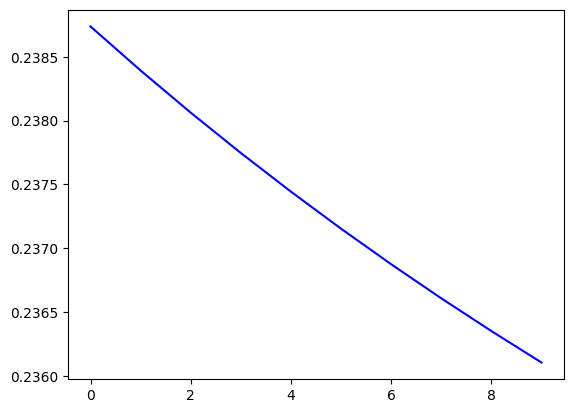

Epoch 10: loss is 0.23610
Epoch 11: loss is 0.23587
Epoch 12: loss is 0.23564
Epoch 13: loss is 0.23542
Epoch 14: loss is 0.23521
Epoch 15: loss is 0.23500
Epoch 16: loss is 0.23481
Epoch 17: loss is 0.23462
Epoch 18: loss is 0.23443
Epoch 19: loss is 0.23426


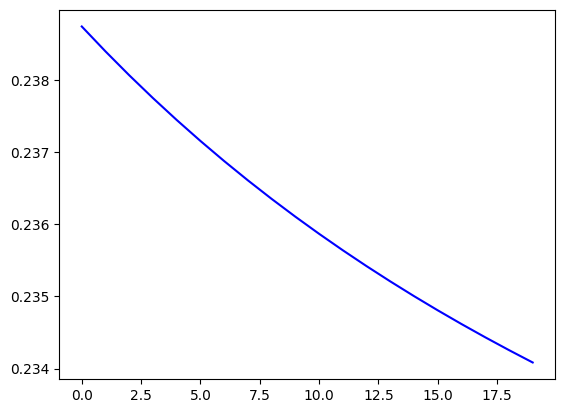

Epoch 20: loss is 0.23409
Epoch 21: loss is 0.23392
Epoch 22: loss is 0.23376
Epoch 23: loss is 0.23360
Epoch 24: loss is 0.23345
Epoch 25: loss is 0.23330
Epoch 26: loss is 0.23316
Epoch 27: loss is 0.23302
Epoch 28: loss is 0.23288
Epoch 29: loss is 0.23275


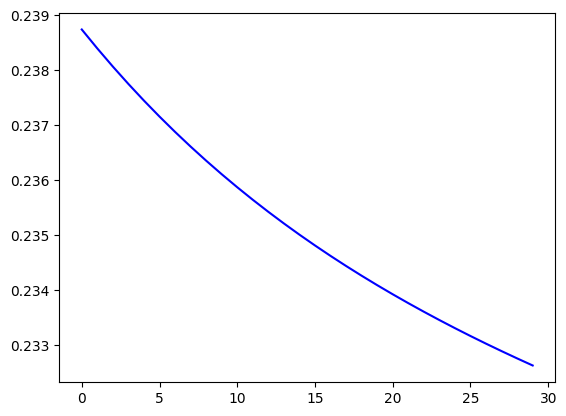

Epoch 30: loss is 0.23262
Epoch 31: loss is 0.23250
Epoch 32: loss is 0.23237
Epoch 33: loss is 0.23225
Epoch 34: loss is 0.23214
Epoch 35: loss is 0.23202
Epoch 36: loss is 0.23191
Epoch 37: loss is 0.23180
Epoch 38: loss is 0.23169
Epoch 39: loss is 0.23158


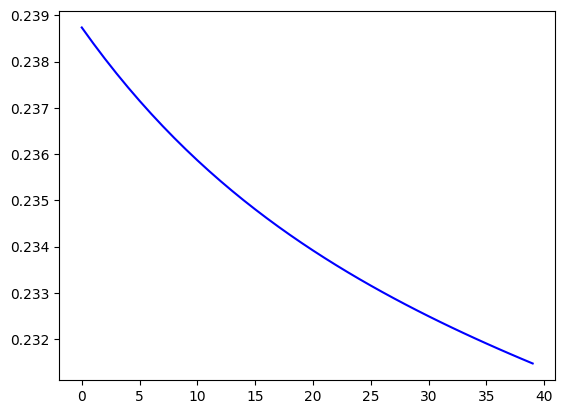

Epoch 40: loss is 0.23148
Epoch 41: loss is 0.23137
Epoch 42: loss is 0.23127
Epoch 43: loss is 0.23117
Epoch 44: loss is 0.23107
Epoch 45: loss is 0.23098
Epoch 46: loss is 0.23088
Epoch 47: loss is 0.23078
Epoch 48: loss is 0.23069
Epoch 49: loss is 0.23060


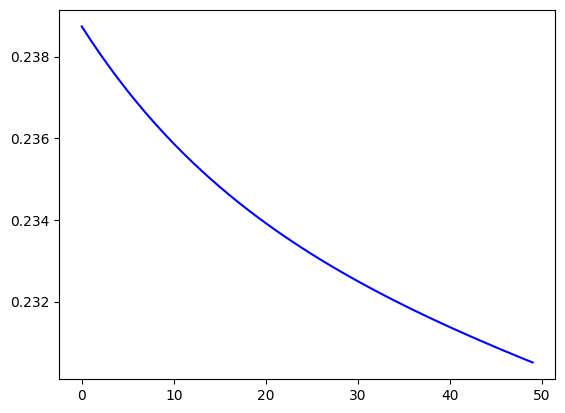

Epoch 50: loss is 0.23051
Epoch 51: loss is 0.23042
Epoch 52: loss is 0.23033
Epoch 53: loss is 0.23024
Epoch 54: loss is 0.23015
Epoch 55: loss is 0.23006
Epoch 56: loss is 0.22997
Epoch 57: loss is 0.22989
Epoch 58: loss is 0.22980
Epoch 59: loss is 0.22972


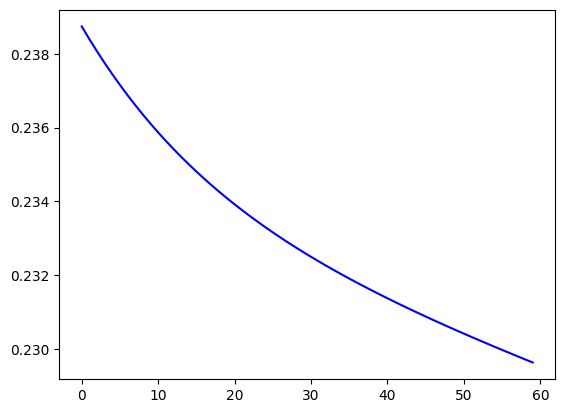

Epoch 60: loss is 0.22963
Epoch 61: loss is 0.22955
Epoch 62: loss is 0.22947
Epoch 63: loss is 0.22938
Epoch 64: loss is 0.22930
Epoch 65: loss is 0.22922
Epoch 66: loss is 0.22914
Epoch 67: loss is 0.22906
Epoch 68: loss is 0.22898
Epoch 69: loss is 0.22890


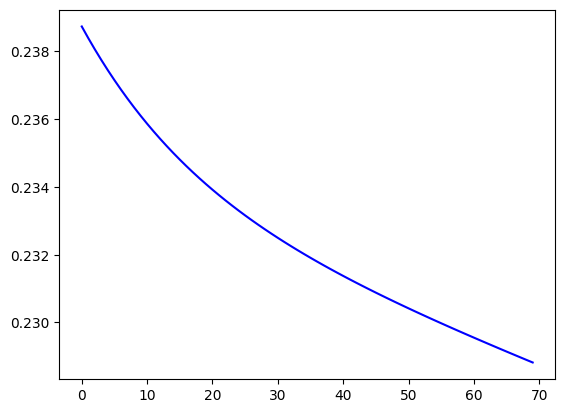

Epoch 70: loss is 0.22882
Epoch 71: loss is 0.22874
Epoch 72: loss is 0.22866
Epoch 73: loss is 0.22858
Epoch 74: loss is 0.22850
Epoch 75: loss is 0.22842
Epoch 76: loss is 0.22834
Epoch 77: loss is 0.22826
Epoch 78: loss is 0.22819
Epoch 79: loss is 0.22811


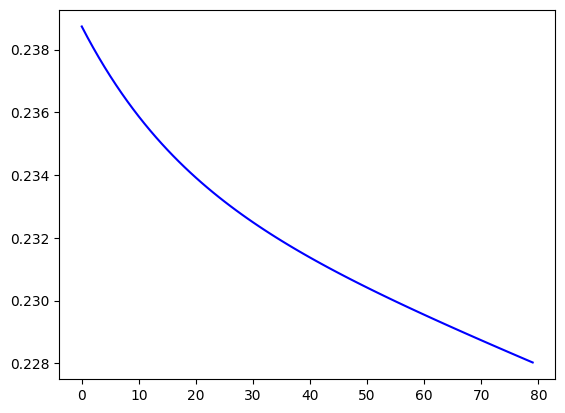

Epoch 80: loss is 0.22803
Epoch 81: loss is 0.22795
Epoch 82: loss is 0.22787
Epoch 83: loss is 0.22780
Epoch 84: loss is 0.22772
Epoch 85: loss is 0.22764
Epoch 86: loss is 0.22757
Epoch 87: loss is 0.22749
Epoch 88: loss is 0.22741
Epoch 89: loss is 0.22734


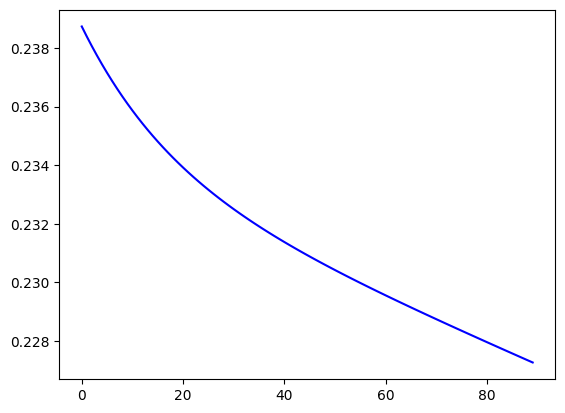

Epoch 90: loss is 0.22726
Epoch 91: loss is 0.22718
Epoch 92: loss is 0.22711
Epoch 93: loss is 0.22703
Epoch 94: loss is 0.22696
Epoch 95: loss is 0.22688
Epoch 96: loss is 0.22680
Epoch 97: loss is 0.22673
Epoch 98: loss is 0.22665
Epoch 99: loss is 0.22658


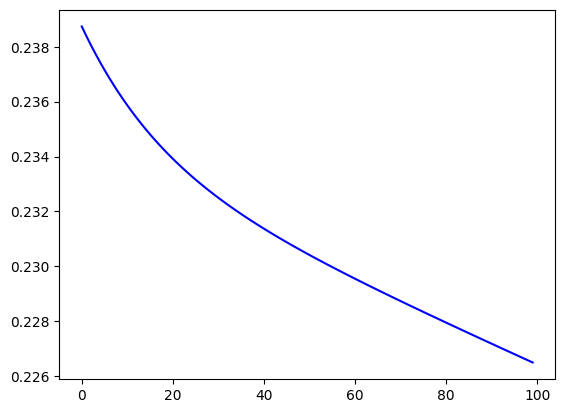

Epoch 100: loss is 0.22650
Epoch 101: loss is 0.22642
Epoch 102: loss is 0.22635
Epoch 103: loss is 0.22627
Epoch 104: loss is 0.22620
Epoch 105: loss is 0.22612
Epoch 106: loss is 0.22605
Epoch 107: loss is 0.22597
Epoch 108: loss is 0.22590
Epoch 109: loss is 0.22582


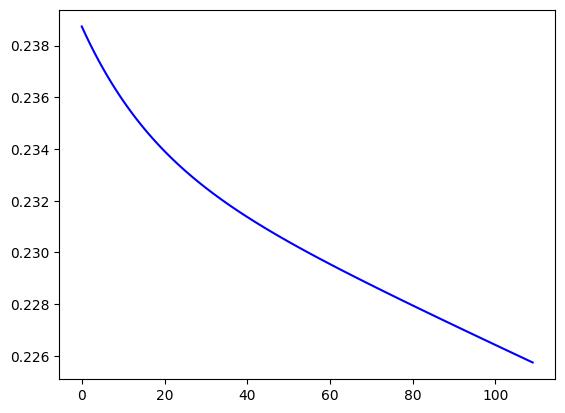

Epoch 110: loss is 0.22575
Epoch 111: loss is 0.22567
Epoch 112: loss is 0.22560
Epoch 113: loss is 0.22552
Epoch 114: loss is 0.22545
Epoch 115: loss is 0.22537
Epoch 116: loss is 0.22530
Epoch 117: loss is 0.22522
Epoch 118: loss is 0.22515
Epoch 119: loss is 0.22507


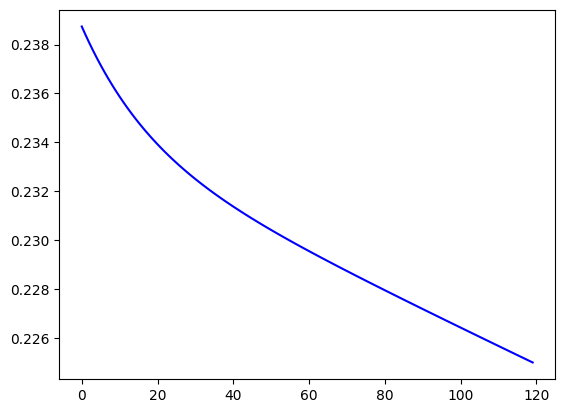

Epoch 120: loss is 0.22500
Epoch 121: loss is 0.22492
Epoch 122: loss is 0.22485
Epoch 123: loss is 0.22478
Epoch 124: loss is 0.22470
Epoch 125: loss is 0.22463
Epoch 126: loss is 0.22455
Epoch 127: loss is 0.22448
Epoch 128: loss is 0.22440
Epoch 129: loss is 0.22433


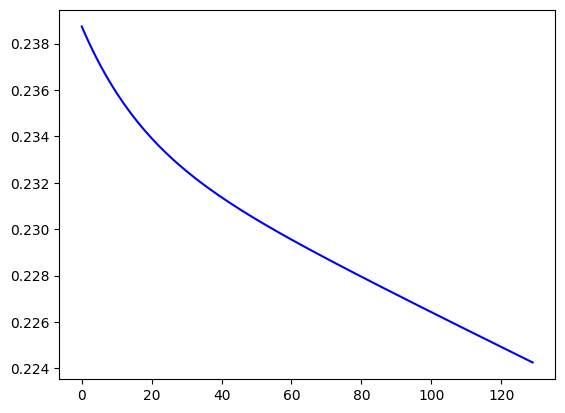

Epoch 130: loss is 0.22425
Epoch 131: loss is 0.22418
Epoch 132: loss is 0.22411
Epoch 133: loss is 0.22403
Epoch 134: loss is 0.22396
Epoch 135: loss is 0.22388
Epoch 136: loss is 0.22381
Epoch 137: loss is 0.22374
Epoch 138: loss is 0.22366
Epoch 139: loss is 0.22359


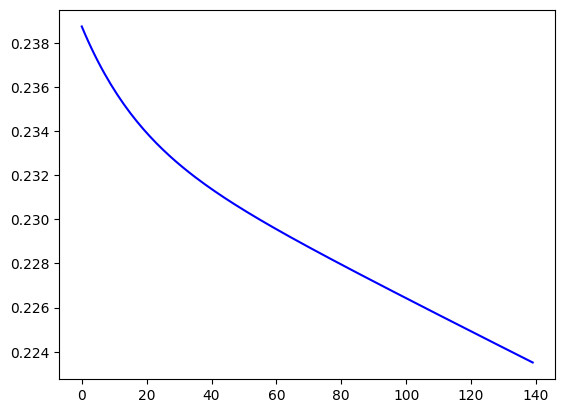

Epoch 140: loss is 0.22351
Epoch 141: loss is 0.22344
Epoch 142: loss is 0.22336
Epoch 143: loss is 0.22329
Epoch 144: loss is 0.22322
Epoch 145: loss is 0.22314
Epoch 146: loss is 0.22307
Epoch 147: loss is 0.22299
Epoch 148: loss is 0.22292
Epoch 149: loss is 0.22285


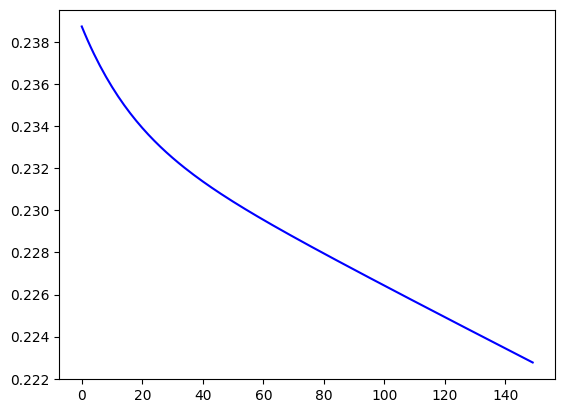

Epoch 150: loss is 0.22277
Epoch 151: loss is 0.22270
Epoch 152: loss is 0.22262
Epoch 153: loss is 0.22255
Epoch 154: loss is 0.22248
Epoch 155: loss is 0.22240
Epoch 156: loss is 0.22233
Epoch 157: loss is 0.22226
Epoch 158: loss is 0.22218
Epoch 159: loss is 0.22211


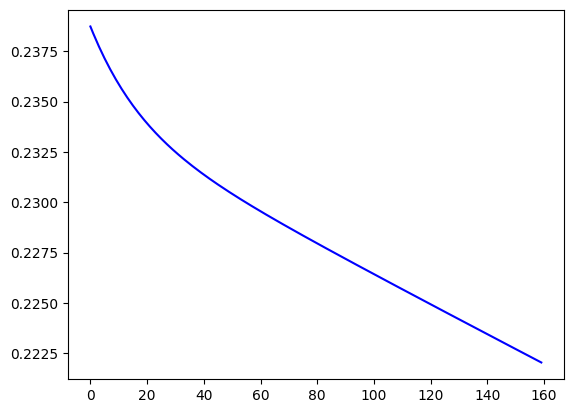

Epoch 160: loss is 0.22203
Epoch 161: loss is 0.22196
Epoch 162: loss is 0.22189
Epoch 163: loss is 0.22181
Epoch 164: loss is 0.22174
Epoch 165: loss is 0.22167
Epoch 166: loss is 0.22159
Epoch 167: loss is 0.22152
Epoch 168: loss is 0.22144
Epoch 169: loss is 0.22137


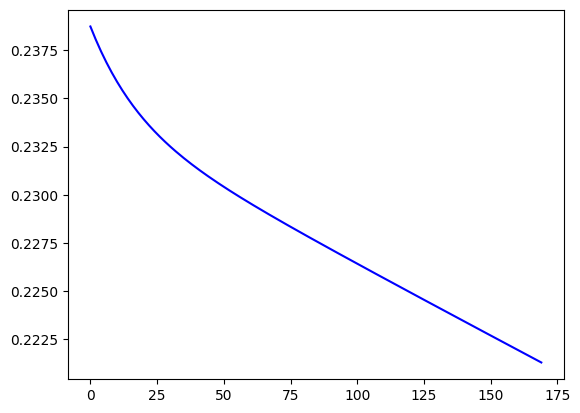

Epoch 170: loss is 0.22130
Epoch 171: loss is 0.22122
Epoch 172: loss is 0.22115
Epoch 173: loss is 0.22108
Epoch 174: loss is 0.22100
Epoch 175: loss is 0.22093
Epoch 176: loss is 0.22085
Epoch 177: loss is 0.22078
Epoch 178: loss is 0.22071
Epoch 179: loss is 0.22063


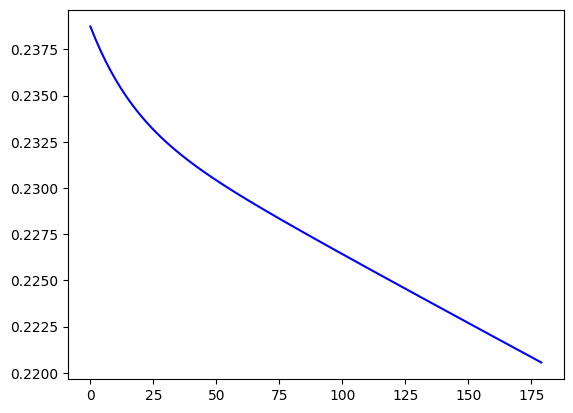

Epoch 180: loss is 0.22056
Epoch 181: loss is 0.22049
Epoch 182: loss is 0.22041
Epoch 183: loss is 0.22034
Epoch 184: loss is 0.22027
Epoch 185: loss is 0.22019
Epoch 186: loss is 0.22012
Epoch 187: loss is 0.22004
Epoch 188: loss is 0.21997
Epoch 189: loss is 0.21990


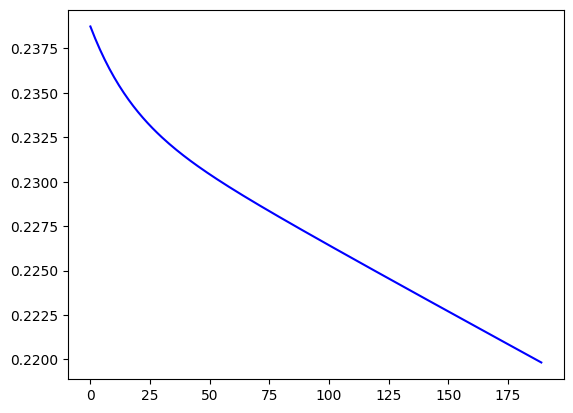

Epoch 190: loss is 0.21982
Epoch 191: loss is 0.21975
Epoch 192: loss is 0.21968
Epoch 193: loss is 0.21960
Epoch 194: loss is 0.21953
Epoch 195: loss is 0.21946
Epoch 196: loss is 0.21938
Epoch 197: loss is 0.21931
Epoch 198: loss is 0.21924
Epoch 199: loss is 0.21916


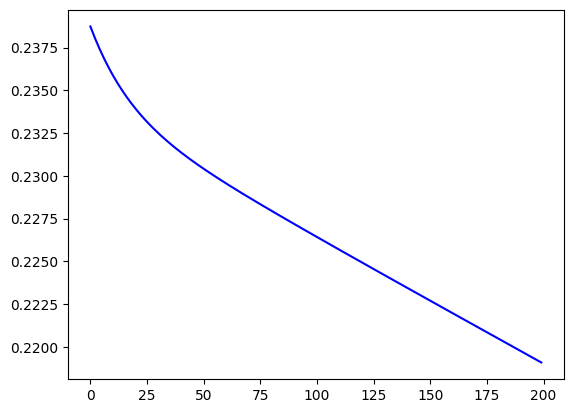

Epoch 200: loss is 0.21909
Epoch 201: loss is 0.21901
Epoch 202: loss is 0.21894
Epoch 203: loss is 0.21887
Epoch 204: loss is 0.21879
Epoch 205: loss is 0.21872
Epoch 206: loss is 0.21865
Epoch 207: loss is 0.21857
Epoch 208: loss is 0.21850
Epoch 209: loss is 0.21843


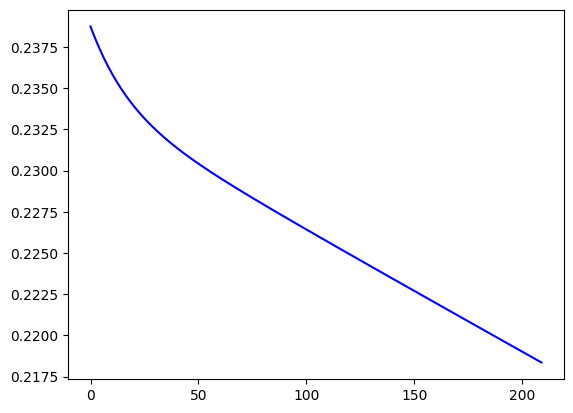

Epoch 210: loss is 0.21835
Epoch 211: loss is 0.21828
Epoch 212: loss is 0.21820
Epoch 213: loss is 0.21813
Epoch 214: loss is 0.21806
Epoch 215: loss is 0.21798
Epoch 216: loss is 0.21791
Epoch 217: loss is 0.21784
Epoch 218: loss is 0.21776
Epoch 219: loss is 0.21769


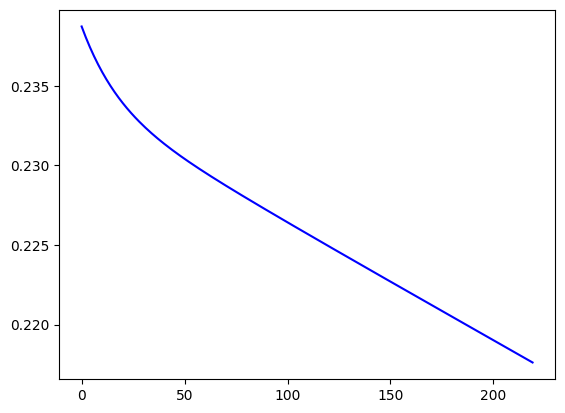

Epoch 220: loss is 0.21762
Epoch 221: loss is 0.21754
Epoch 222: loss is 0.21747
Epoch 223: loss is 0.21739
Epoch 224: loss is 0.21732
Epoch 225: loss is 0.21725
Epoch 226: loss is 0.21717
Epoch 227: loss is 0.21710
Epoch 228: loss is 0.21703
Epoch 229: loss is 0.21695


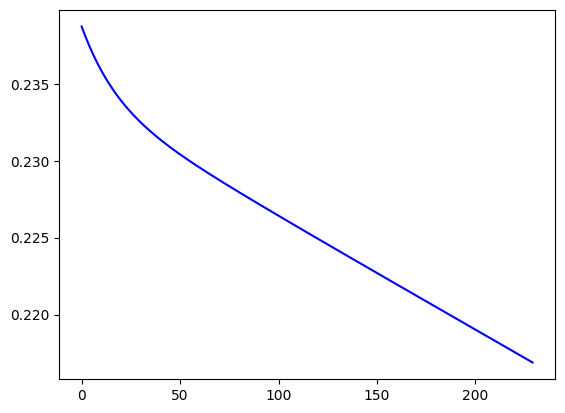

Epoch 230: loss is 0.21688
Epoch 231: loss is 0.21681
Epoch 232: loss is 0.21673
Epoch 233: loss is 0.21666
Epoch 234: loss is 0.21658
Epoch 235: loss is 0.21651
Epoch 236: loss is 0.21644
Epoch 237: loss is 0.21636
Epoch 238: loss is 0.21629
Epoch 239: loss is 0.21621


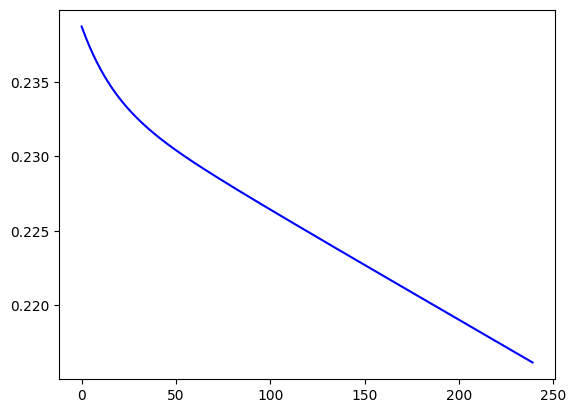

Epoch 240: loss is 0.21614
Epoch 241: loss is 0.21607
Epoch 242: loss is 0.21599
Epoch 243: loss is 0.21592
Epoch 244: loss is 0.21585
Epoch 245: loss is 0.21577
Epoch 246: loss is 0.21570
Epoch 247: loss is 0.21562
Epoch 248: loss is 0.21555
Epoch 249: loss is 0.21548


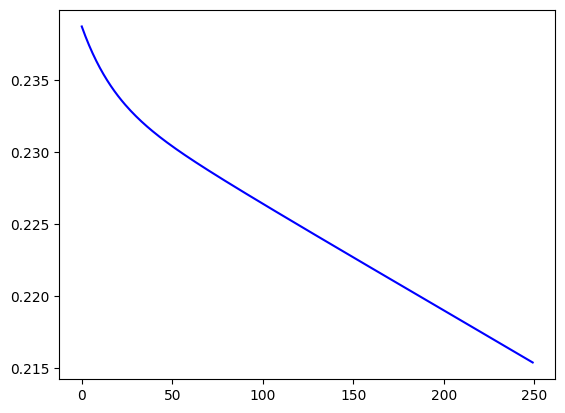

Epoch 250: loss is 0.21540
Epoch 251: loss is 0.21533
Epoch 252: loss is 0.21525
Epoch 253: loss is 0.21518
Epoch 254: loss is 0.21511
Epoch 255: loss is 0.21503
Epoch 256: loss is 0.21496
Epoch 257: loss is 0.21488
Epoch 258: loss is 0.21481
Epoch 259: loss is 0.21474


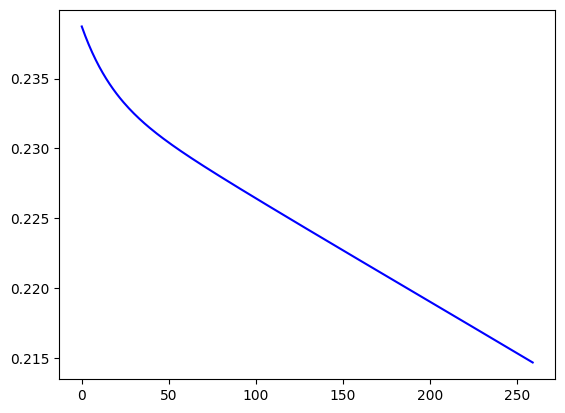

Epoch 260: loss is 0.21466
Epoch 261: loss is 0.21459
Epoch 262: loss is 0.21451
Epoch 263: loss is 0.21444
Epoch 264: loss is 0.21436
Epoch 265: loss is 0.21429
Epoch 266: loss is 0.21422
Epoch 267: loss is 0.21414
Epoch 268: loss is 0.21407
Epoch 269: loss is 0.21399


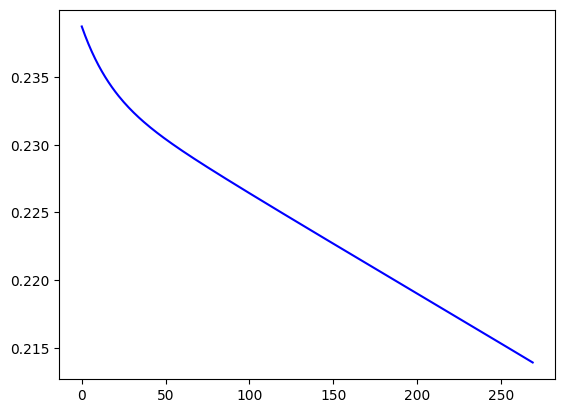

Epoch 270: loss is 0.21392
Epoch 271: loss is 0.21384
Epoch 272: loss is 0.21377
Epoch 273: loss is 0.21370
Epoch 274: loss is 0.21362
Epoch 275: loss is 0.21355
Epoch 276: loss is 0.21347
Epoch 277: loss is 0.21340
Epoch 278: loss is 0.21332
Epoch 279: loss is 0.21325


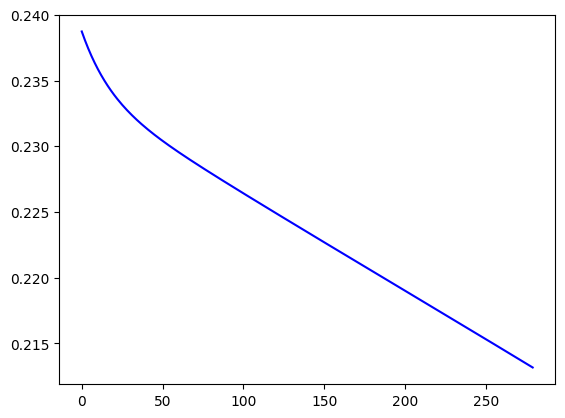

Epoch 280: loss is 0.21317
Epoch 281: loss is 0.21310
Epoch 282: loss is 0.21302
Epoch 283: loss is 0.21295
Epoch 284: loss is 0.21288
Epoch 285: loss is 0.21280
Epoch 286: loss is 0.21273
Epoch 287: loss is 0.21265
Epoch 288: loss is 0.21258
Epoch 289: loss is 0.21250


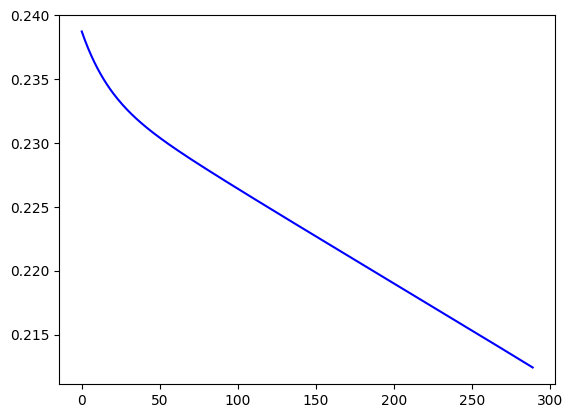

Epoch 290: loss is 0.21243
Epoch 291: loss is 0.21235
Epoch 292: loss is 0.21228
Epoch 293: loss is 0.21220
Epoch 294: loss is 0.21213
Epoch 295: loss is 0.21205
Epoch 296: loss is 0.21198
Epoch 297: loss is 0.21190
Epoch 298: loss is 0.21183
Epoch 299: loss is 0.21175


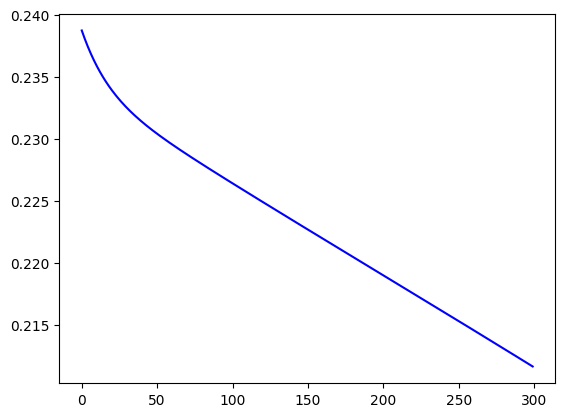

Epoch 300: loss is 0.21168
Epoch 301: loss is 0.21160
Epoch 302: loss is 0.21153
Epoch 303: loss is 0.21145
Epoch 304: loss is 0.21138
Epoch 305: loss is 0.21130
Epoch 306: loss is 0.21123
Epoch 307: loss is 0.21115
Epoch 308: loss is 0.21108
Epoch 309: loss is 0.21100


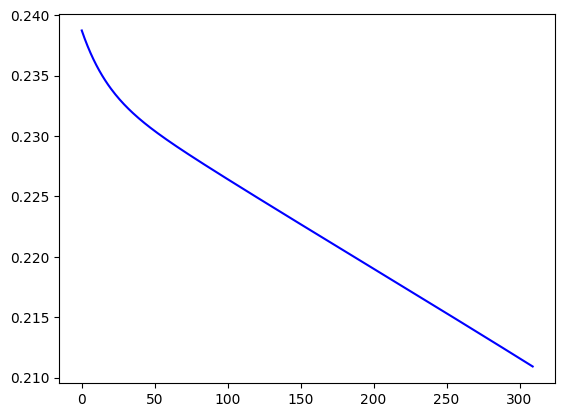

Epoch 310: loss is 0.21092
Epoch 311: loss is 0.21085
Epoch 312: loss is 0.21077
Epoch 313: loss is 0.21070
Epoch 314: loss is 0.21062
Epoch 315: loss is 0.21055
Epoch 316: loss is 0.21047
Epoch 317: loss is 0.21040
Epoch 318: loss is 0.21032
Epoch 319: loss is 0.21025


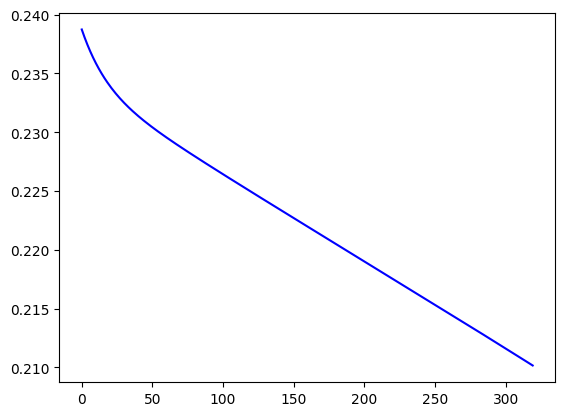

Epoch 320: loss is 0.21017
Epoch 321: loss is 0.21009
Epoch 322: loss is 0.21002
Epoch 323: loss is 0.20994
Epoch 324: loss is 0.20987
Epoch 325: loss is 0.20979
Epoch 326: loss is 0.20971
Epoch 327: loss is 0.20964
Epoch 328: loss is 0.20956
Epoch 329: loss is 0.20949


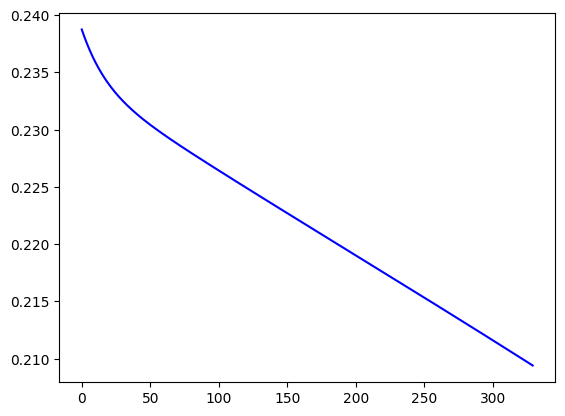

Epoch 330: loss is 0.20941
Epoch 331: loss is 0.20934
Epoch 332: loss is 0.20926
Epoch 333: loss is 0.20918
Epoch 334: loss is 0.20911
Epoch 335: loss is 0.20903
Epoch 336: loss is 0.20895
Epoch 337: loss is 0.20888
Epoch 338: loss is 0.20880
Epoch 339: loss is 0.20873


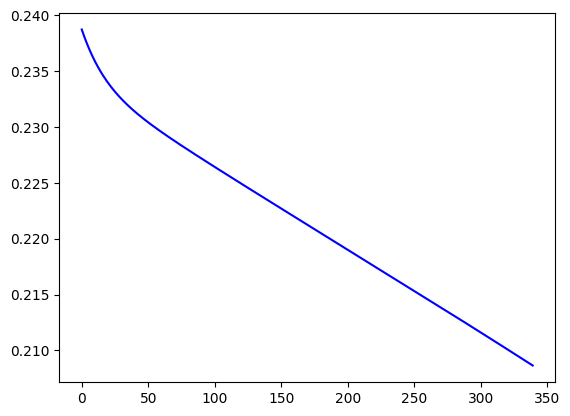

Epoch 340: loss is 0.20865
Epoch 341: loss is 0.20857
Epoch 342: loss is 0.20850
Epoch 343: loss is 0.20842
Epoch 344: loss is 0.20834
Epoch 345: loss is 0.20827
Epoch 346: loss is 0.20819
Epoch 347: loss is 0.20811
Epoch 348: loss is 0.20804
Epoch 349: loss is 0.20796


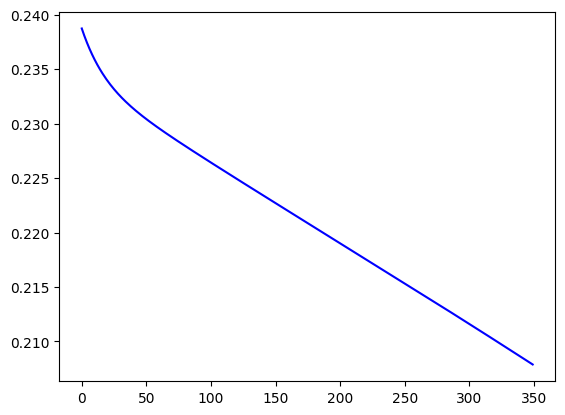

Epoch 350: loss is 0.20788
Confusion matrix:
[[0.75 0.09 0.01 0.03 0.05 0.06 0.01 0.01 0.   0.  ]
 [0.1  0.89 0.   0.   0.01 0.01 0.   0.   0.   0.  ]
 [0.07 0.08 0.25 0.   0.47 0.08 0.04 0.   0.01 0.  ]
 [0.37 0.41 0.   0.09 0.06 0.05 0.01 0.   0.   0.  ]
 [0.06 0.05 0.12 0.01 0.7  0.04 0.01 0.   0.01 0.  ]
 [0.   0.   0.   0.   0.   0.59 0.   0.16 0.   0.24]
 [0.26 0.09 0.06 0.01 0.39 0.12 0.06 0.   0.01 0.01]
 [0.   0.   0.   0.   0.   0.1  0.   0.71 0.   0.19]
 [0.   0.01 0.   0.04 0.1  0.1  0.01 0.06 0.45 0.24]
 [0.   0.   0.   0.   0.01 0.02 0.   0.02 0.01 0.95]]
Diagonal values:
[0.75 0.89 0.25 0.09 0.7  0.59 0.06 0.71 0.45 0.95]
--Return--
None
> c:\users\admin\appdata\local\temp\ipykernel_3276\1522671481.py(12)<module>()

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


In [22]:
if __name__ == '__main__':
    np.random.seed(2017)
    
    #numerical check for your layer feedforward and backpropagation
    your_layer = Layer((60, 100), 'sigmoid')
    # unit_test_layer(your_layer)

    plt.ion()
    # bat_classification()
    mnist_classification()

    pdb.set_trace()

In [ ]:
# # Load data from file
# # Make sure that fashion-mnist/*.gz is in data/
# train_x, train_y, val_x, val_y, test_x, test_y = get_mnist_data(1)
# train_x, val_x, test_x = normalize(train_x, train_x, test_x)    

# num_class = (np.unique(train_y)).shape[0]

# # Pad 1 as the third feature of train_x and test_x
# train_x = add_one(train_x)
# # print(train_x.shape)
# val_x = add_one(val_x)
# test_x = add_one(test_x)

# # Define hyper-parameters and train-related parameters
# cfg = Config(num_epoch=350, learning_rate=0.01, batch_size=200, num_train=train_x.shape[0], visualize=True,reg=1e-3)

# # Create NN classifier
# num_hidden_nodes = 100
# num_hidden_nodes_2 = 100
# num_hidden_nodes_3 = 100
# net = NeuralNet(num_class, cfg.reg)
# net.add_linear_layer((train_x.shape[1],num_hidden_nodes), 'tanh')
# net.add_linear_layer((num_hidden_nodes, num_hidden_nodes_2), 'sigmoid')
# net.add_linear_layer((num_hidden_nodes_2, num_hidden_nodes_3), 'sigmoid')
# net.add_linear_layer((num_hidden_nodes_3, num_class), 'softmax')
    
# #Minibatch training - training dataset using Minibatch approach
# for i in range(0,num_train,batch_size):
#     traix=train_x[i:i+batch_sizem,:]
#     traiy=train_y[i:i+batch_sizem,:]
#     minibatch_train(net, traix, traiy, cfg)

# y_hat = net.forward(test_x)[-1]
# test(y_hat, test_y)

Reading fashion MNIST data...
Done reading
Confusion matrix:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Diagonal values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
